**CIFAR-10, классификация изображений, CNN**

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output

%matplotlib inline
#device = "cuda"

In [11]:
#torch.cuda.is_available()

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=16, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
NUM_EPOCH = 25

In [26]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure(figsize=(5,2))
    plt.title("{}".format(title))
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [15]:
class ModelRELU(nn.Module):
    def __init__(self):
        super(ModelRELU, self).__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


model_1 = ModelRELU()

In [18]:
class ModelLeakyRELU(nn.Module):
    def __init__(self):
        super(ModelLeakyRELU, self).__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.lrelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.lrelu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


model_2 = ModelLeakyRELU()

In [19]:
class ModelELU(nn.Module):
    def __init__(self):
        super(ModelELU, self).__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ELU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.elu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


model_3 = ModelELU()

In [20]:
class ModelSELU(nn.Module):
    def __init__(self):
        super(ModelSELU, self).__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.SELU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.selu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


model_4 = ModelSELU()

In [21]:
#model_baseline.to(device)

In [22]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []

    for epoch in range(NUM_EPOCH):
        model.train()
        train_loss = 0.0
        train_size = 0
        train_acc = 0.0
        for imgs, labels in train_dataloader:
            #imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))

        val_loss = 0.0
        val_size = 0
        val_acc = 0.0
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                #imgs, labels = imgs.to(device), labels.to(device)
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_loss / train_size)
        print("Train acc:", train_acc / train_size)
        print("Val loss:", val_loss / val_size)
        print("Val acc:", val_acc / val_size)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9)
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.001, momentum=0.9)

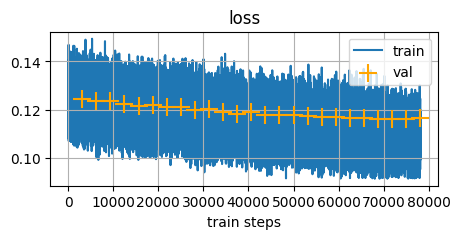

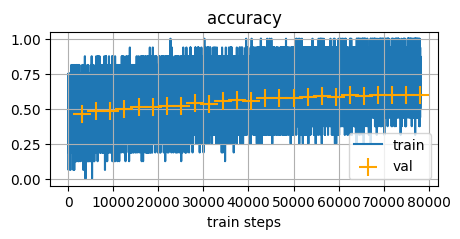

Train loss: 0.10780690843820571
Train acc: 0.74046
Val loss: 0.11645907652378082
Val acc: 0.5958


In [30]:
train(model_1, criterion, optimizer_1, train_dataloader, test_dataloader)

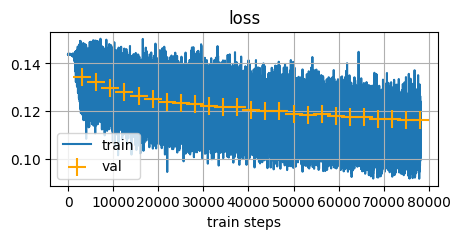

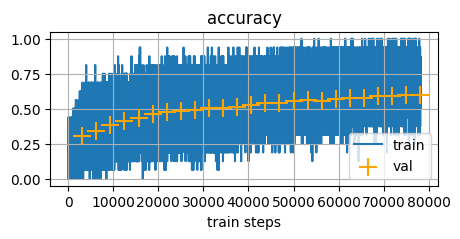

Train loss: 0.10992212526321411
Train acc: 0.70712
Val loss: 0.11630004148483276
Val acc: 0.5982


In [31]:
train(model_2, criterion, optimizer_2, train_dataloader, test_dataloader)

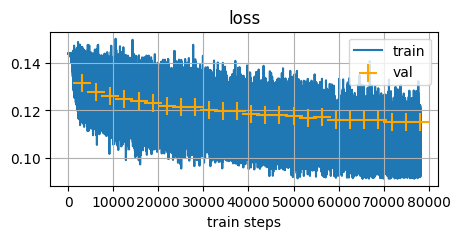

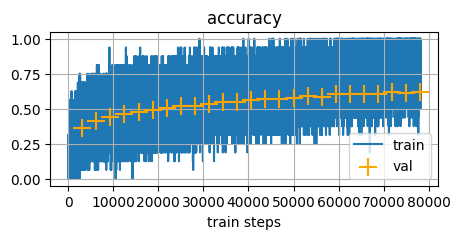

Train loss: 0.10618497198581696
Train acc: 0.76816
Val loss: 0.11502257112264633
Val acc: 0.6204


In [32]:
train(model_3, criterion, optimizer_3, train_dataloader, test_dataloader)

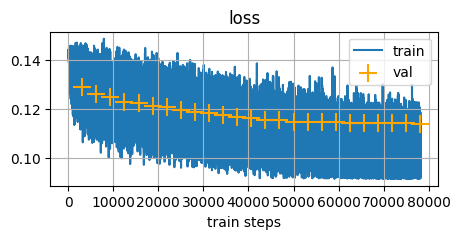

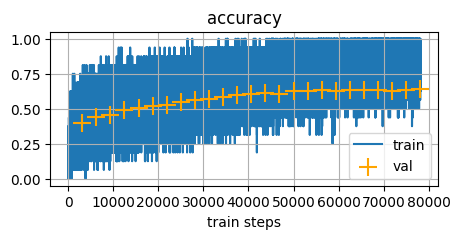

Train loss: 0.10316649638652801
Train acc: 0.81512
Val loss: 0.1137704136967659
Val acc: 0.6377


In [33]:
train(model_4, criterion, optimizer_4, train_dataloader, test_dataloader)